<a href="https://colab.research.google.com/github/AljokExe/CNN-bacteria/blob/main/0_97_grid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Funghi Classification v3


Usefull imports, try to keep all of them here and labeled!

In [ ]:
''' Linear Algebra'''
import pandas as pd
import numpy as np

''' Data visualization'''
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


'''Image loading I believe'''
from tqdm import tqdm
from PIL import Image

Don't forget to enable GPU acceleration!

`Runtime` $\rightarrow$ `Change runtime type` $\rightarrow$ `Hardware accelerator` $\rightarrow$ `GPU`

Mount your google drive!

In [ ]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/drive')
# Put Colab in the context of this challenge
import os
# os.chdir allows you to change directories, like cd in the Terminal
my_drive_path="/Colab Notebooks/data-transfer-learning"  #Change accordingly to the path of your project folder
os.chdir('/content/drive/MyDrive'+my_drive_path) 

Mounted at /content/drive


## (1) Dataset Loading

In [ ]:
!pwd #Check path of your mounted drive

/content/drive/MyDrive/Colab Notebooks/data-transfer-learning


In [ ]:
!ls #List the contents of the directory you are in

 AGAR_examples_200_per_class   flowers		     README.md
'Confusion matrix.png'	       flowers-dataset.zip   transfer_learning.ipynb


In [ ]:
def load_data(classes_input, data_path_input):

    data_path =data_path_input 
    classes = classes_input 
    imgs = []
    labels = []
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.jpg')>0]
        for img in tqdm(images_path[:300]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = image.resize((256, 256))
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)

    # Finally we shuffle:
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    first_split = int(len(imgs) /6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

Use the following method to create 
`X_train, y_train, X_val, y_val, X_test, y_test, num_classes` depending on the `classes & path` you want to use:

In [ ]:
# CALL load_data with your preferred PATH and LABELS here
classes_input= {'B.subtilis':0,
                'C.albicans':1,
                'E.coli':2,
                'P.aeruginosa':3,
                'S.aureus':4}

data_path_input = '/content/drive/My Drive/Colab Notebooks/data-transfer-learning/AGAR_examples_200_per_class'
X_train, y_train, X_val, y_val, X_test, y_test, num_classes=load_data(classes_input, data_path_input)

100%|██████████| 200/200 [01:00<00:00,  3.33it/s]


## (2) Visualizing dataset


In [ ]:
print("Train_shape: ",X_train.shape,y_train.shape)
print("Val_shape: ",X_val.shape, y_val.shape)
print("Test_shape: ",X_test.shape,y_test.shape)
print("Num_classes: ",num_classes)
print(y_train.sum(axis=0),y_val.sum(axis=0),y_test.sum(axis=0))

Train_shape:  (634, 256, 256, 3) (634, 5)
Val_shape:  (200, 256, 256, 3) (200, 5)
Test_shape:  (166, 256, 256, 3) (166, 5)
Num_classes:  5
[126. 126. 119. 129. 134.] [36. 48. 41. 40. 35.] [38. 26. 40. 31. 31.]


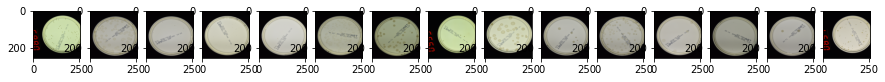

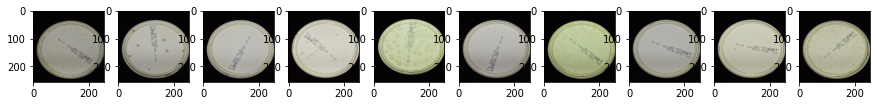

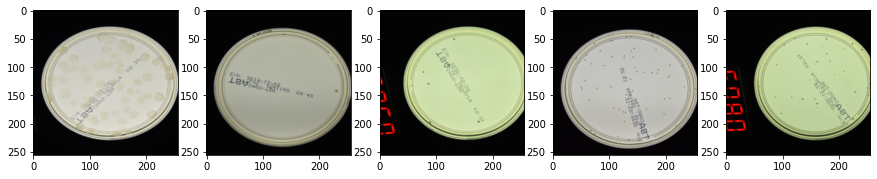

In [ ]:
# # Visualization order of rows: Training, Validating, Testing data
# #ATTENTION: WE MUST REDUCE WHEN WE HAVE MORE DATA
# plt.figure(figsize=(15,5))
# for i in range(15):
#     plt.subplot(1,15, i+1)
#     img = X_train[i]
#     plt.imshow(img)
# plt.figure(figsize=(15,5))
# for i in range(10):
#     plt.subplot(1,10, i+1)
#     img = X_val[i]
#     plt.imshow(img)
# plt.figure(figsize=(15,5))
# for i in range(5):
#     plt.subplot(1,5, i+1)
#     img = X_test[i]
#     plt.imshow(img)

## (3) Data Augmentation (TESTING)

❓ Question: Should we create a cycle that keeps using the augmented data to create even more augmented data, or simply augment from the same X_train every time?
❓

First we create our image generating model and train it on our X_train.

In [ ]:
datagen = ImageDataGenerator(
    #featurewise_center = False,
    #featurewise_std_normalization = False,
    #rotation_range = 10,
    width_shift_range = 100,
    height_shift_range = 100,
    horizontal_flip = True,
    #zoom_range = (0.8, 1.2),
    ) 
datagen.fit(X_train)
datagen

Then we create our augmented data.

In [ ]:
X_augmented_iterator = datagen.flow(X_train, shuffle=False, batch_size=1)
#print(X_train[0].shape)
#print(X_train[0][0].shape)
#print(X_augmented_iterator[0].shape)
#print(X_augmented_iterator[0][0].shape)

Plotting our data next to our augmented data.
`Comments below are simply tests to actually expand the data. As of now, expanded data is not in use`

In [ ]:

# X_augmented_iterator_2 = datagen.flow(X_train, shuffle=False, batch_size=1)#X_train_2
# import numpy as np
# counter=0

# for i, (raw_image, augmented_image) in enumerate(zip(X_train, X_augmented_iterator)): #X_train_2 X_augmented_iterator_2
#     counter=counter+1
#     _, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))
#     ax1.imshow((raw_image).astype(np.uint8))
#     ax2.imshow((augmented_image[0]).astype(np.uint8))
#     plt.show()
# counter

## (4) Using a pre-trained CNN = Transfer learning

### (4.1) Load VGG16 model

Have a look at the documentation 📚  [tf/keras/applications/VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16)📚


First we create a function to load the model:

In [64]:
from numpy.lib.function_base import average
def load_model():
    
    model=VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(256,256,3),
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
    )
    
    return model

Then we create a second function to lock the trainability of the layers we want to remain untouched:

In [65]:
def set_nontrainable_layers(model):
    model.trainable=True
    return model

At last we sequentialize all the previous steps with our custom layers (highlighted with comments):

In [66]:
def final_architecture():
    base_model = load_model()
    base_model = set_nontrainable_layers(base_model)

    #############
    flattening_layer = layers.Flatten()
    dense_layer = layers.Dense(50, activation='relu')
    prediction_layer = layers.Dense(num_classes, activation='softmax')#don't edit this one, only layers above it
    #############

    model = Sequential([
      base_model,
      flattening_layer,
      dense_layer,
      prediction_layer
    ])
    return model

Visualize the parameters of our final architecture:

In [67]:
model=final_architecture()
model.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_49 (Flatten)        (None, 32768)             0         
                                                                 
 dense_98 (Dense)            (None, 50)                1638450   
                                                                 
 dense_99 (Dense)            (None, 5)                 255       
                                                                 
Total params: 16,353,393
Trainable params: 16,353,393
Non-trainable params: 0
_________________________________________________________________


We finalize our module with a custom made compilation function.
❓ Question: Could Adam be the best optimizer? Should other metrics be tested?
❓

In [68]:
def build_model():
    model_compiled=final_architecture()

    opt=Adam(
    learning_rate=1e-4
    )

    model_compiled.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return model_compiled

# metrics=[Accuracy(name='accuracy'),tfa.metrics.F1Score(num_classes=5, average="weighted")]

# metrics=['accuracy']

### (5.2) VGG Preprocessing (preparation to use fit our data)

In [69]:
X_train_end = preprocess_input(X_train)#X_train_2
X_val_end = preprocess_input(X_val)
X_test_end = preprocess_input(X_test)
#X_train_end.shape

### (5.3)  EUREKA, we can fit the model

In [70]:
model_final=build_model()

es = EarlyStopping(
    patience=50,
    monitor='val_accuracy', # We really want to dete
    restore_best_weights=True)


history=model_final.fit(X_train_end, y_train,
          epochs=1000,  # Use early stopping in practice
          validation_data=(X_val_end, y_val),
          batch_size=16, 
          verbose=1,
         callbacks=[es])

Epoch 1/1000
40/40 [==============================] - 4s 65ms/step - loss: 2.0019 - accuracy: 0.2997 - val_loss: 1.4285 - val_accuracy: 0.4100
Epoch 2/1000
40/40 [==============================] - 2s 52ms/step - loss: 1.2855 - accuracy: 0.4196 - val_loss: 1.2461 - val_accuracy: 0.4450
Epoch 3/1000
40/40 [==============================] - 2s 53ms/step - loss: 1.0161 - accuracy: 0.5678 - val_loss: 1.0308 - val_accuracy: 0.6400
Epoch 4/1000
40/40 [==============================] - 2s 52ms/step - loss: 0.8325 - accuracy: 0.6483 - val_loss: 0.9208 - val_accuracy: 0.6900
Epoch 5/1000
40/40 [==============================] - 2s 51ms/step - loss: 0.7250 - accuracy: 0.7019 - val_loss: 0.8708 - val_accuracy: 0.6700
Epoch 6/1000
40/40 [==============================] - 2s 52ms/step - loss: 0.6257 - accuracy: 0.7461 - val_loss: 0.7892 - val_accuracy: 0.7400
Epoch 7/1000
40/40 [==============================] - 2s 52ms/step - loss: 0.6027 - accuracy: 0.7492 - val_loss: 0.7300 - val_accuracy: 0.7000

In [26]:
# define the grid search parameters

batch_size = [8,16]
epochs = [10]

param_grid = dict(batch_size=batch_size, epochs=epochs)

# tensorflow keras have a wrapper for using keras models with sklearn
#'build_fn' param of the KerasClassifier expects a function to be called

Kmodel = KerasClassifier(build_fn=build_model, verbose=1)

grid = GridSearchCV(estimator=Kmodel, param_grid=param_grid ,scoring='accuracy')
grid_result = grid.fit(X_train_end, y_train, validation_data=(X_val_end, y_val))

# summarize results

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/100
64/64 [==============================] - 4s 40ms/step - loss: 2.1134 - accuracy: 0.2347 - val_loss: 1.5647 - val_accuracy: 0.2300
Epoch 2/100
64/64 [==============================] - 2s 33ms/step - loss: 1.3812 - accuracy: 0.3669 - val_loss: 1.1796 - val_accuracy: 0.4400
Epoch 3/100
64/64 [==============================] - 2s 34ms/step - loss: 1.1586 - accuracy: 0.5069 - val_loss: 1.2193 - val_accuracy: 0.4350
Epoch 4/100
64/64 [==============================] - 2s 33ms/step - loss: 1.0252 - accuracy: 0.5582 - val_loss: 1.3567 - val_accuracy: 0.3750
Epoch 5/100
64/64 [==============================] - 2s 33ms/step - loss: 1.0302 - accuracy: 0.5207 - val_loss: 0.8191 - val_accuracy: 0.6150
Epoch 6/100
64/64 [==============================] - 2s 33ms/step - loss: 0.7130 - accuracy: 0.6943 - val_loss: 0.8009 - val_accuracy: 0.6450
Epoch 7/100
64/64 [==============================] - 2s 33ms/step - loss: 0.6683 - accuracy: 0.7081 - val_loss: 0.6088 - val_accuracy: 0.7500
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
    type_true, type_pred


Epoch 1/100
64/64 [==============================] - 3s 39ms/step - loss: 2.0226 - accuracy: 0.2742 - val_loss: 1.6046 - val_accuracy: 0.2400
Epoch 2/100
64/64 [==============================] - 2s 33ms/step - loss: 1.5576 - accuracy: 0.2327 - val_loss: 1.6122 - val_accuracy: 0.2400
Epoch 3/100
64/64 [==============================] - 2s 33ms/step - loss: 1.5574 - accuracy: 0.2229 - val_loss: 1.6159 - val_accuracy: 0.2200
Epoch 4/100
64/64 [==============================] - 2s 33ms/step - loss: 1.5557 - accuracy: 0.2012 - val_loss: 1.6270 - val_accuracy: 0.2200
Epoch 5/100
64/64 [==============================] - 2s 33ms/step - loss: 1.5553 - accuracy: 0.2465 - val_loss: 1.6267 - val_accuracy: 0.2200
Epoch 6/100
64/64 [==============================] - 2s 33ms/step - loss: 1.5553 - accuracy: 0.2465 - val_loss: 1.6324 - val_accuracy: 0.2200
Epoch 7/100
64/64 [==============================] - 2s 33ms/step - loss: 1.5553 - accuracy: 0.2465 - val_loss: 1.6369 - val_accuracy: 0.2200
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
    type_true, type_pred


Epoch 1/100
64/64 [==============================] - 3s 39ms/step - loss: 1.9584 - accuracy: 0.3609 - val_loss: 1.1909 - val_accuracy: 0.4800
Epoch 2/100
64/64 [==============================] - 2s 33ms/step - loss: 1.0287 - accuracy: 0.5385 - val_loss: 0.8238 - val_accuracy: 0.6450
Epoch 3/100
64/64 [==============================] - 2s 33ms/step - loss: 0.7627 - accuracy: 0.6844 - val_loss: 0.6558 - val_accuracy: 0.6950
Epoch 4/100
64/64 [==============================] - 2s 33ms/step - loss: 0.4916 - accuracy: 0.8087 - val_loss: 0.6212 - val_accuracy: 0.7850
Epoch 5/100
64/64 [==============================] - 2s 33ms/step - loss: 0.3871 - accuracy: 0.8422 - val_loss: 1.0436 - val_accuracy: 0.7400
Epoch 6/100
64/64 [==============================] - 2s 33ms/step - loss: 1.3195 - accuracy: 0.4615 - val_loss: 1.0226 - val_accuracy: 0.5850
Epoch 7/100
64/64 [==============================] - 2s 33ms/step - loss: 0.9745 - accuracy: 0.5996 - val_loss: 1.1514 - val_accuracy: 0.5500
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
    type_true, type_pred


Epoch 1/100
64/64 [==============================] - 3s 40ms/step - loss: 1.9348 - accuracy: 0.3156 - val_loss: 1.1268 - val_accuracy: 0.5250
Epoch 2/100
64/64 [==============================] - 2s 33ms/step - loss: 1.1704 - accuracy: 0.4714 - val_loss: 1.0322 - val_accuracy: 0.5250
Epoch 3/100
64/64 [==============================] - 2s 33ms/step - loss: 1.0075 - accuracy: 0.5404 - val_loss: 0.9899 - val_accuracy: 0.5550
Epoch 4/100
64/64 [==============================] - 2s 33ms/step - loss: 1.0120 - accuracy: 0.5996 - val_loss: 1.0503 - val_accuracy: 0.5800
Epoch 5/100
64/64 [==============================] - 2s 33ms/step - loss: 0.8530 - accuracy: 0.6509 - val_loss: 0.8326 - val_accuracy: 0.7050
Epoch 6/100
64/64 [==============================] - 2s 33ms/step - loss: 0.7087 - accuracy: 0.7298 - val_loss: 0.8129 - val_accuracy: 0.6600
Epoch 7/100
64/64 [==============================] - 2s 33ms/step - loss: 0.6740 - accuracy: 0.7318 - val_loss: 0.8210 - val_accuracy: 0.7000
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
    type_true, type_pred


Epoch 1/100
64/64 [==============================] - 4s 48ms/step - loss: 2.0876 - accuracy: 0.2047 - val_loss: 1.6008 - val_accuracy: 0.2800
Epoch 2/100
64/64 [==============================] - 2s 33ms/step - loss: 1.6080 - accuracy: 0.2087 - val_loss: 1.5960 - val_accuracy: 0.2550
Epoch 3/100
64/64 [==============================] - 2s 33ms/step - loss: 1.6353 - accuracy: 0.2323 - val_loss: 1.5869 - val_accuracy: 0.2900
Epoch 4/100
64/64 [==============================] - 2s 33ms/step - loss: 1.5624 - accuracy: 0.3051 - val_loss: 1.3922 - val_accuracy: 0.3650
Epoch 5/100
64/64 [==============================] - 2s 33ms/step - loss: 1.3313 - accuracy: 0.3898 - val_loss: 1.1814 - val_accuracy: 0.4500
Epoch 6/100
64/64 [==============================] - 2s 33ms/step - loss: 1.2309 - accuracy: 0.4665 - val_loss: 1.0667 - val_accuracy: 0.5750
Epoch 7/100
64/64 [==============================] - 2s 33ms/step - loss: 1.1091 - accuracy: 0.5610 - val_loss: 1.1522 - val_accuracy: 0.5050
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
    type_true, type_pred


Epoch 1/100
32/32 [==============================] - 5s 88ms/step - loss: 1.8591 - accuracy: 0.4418 - val_loss: 1.0919 - val_accuracy: 0.5100
Epoch 2/100
32/32 [==============================] - 2s 51ms/step - loss: 0.9259 - accuracy: 0.5976 - val_loss: 0.8737 - val_accuracy: 0.5900
Epoch 3/100
32/32 [==============================] - 2s 51ms/step - loss: 0.6934 - accuracy: 0.7337 - val_loss: 0.8066 - val_accuracy: 0.7000
Epoch 4/100
32/32 [==============================] - 2s 51ms/step - loss: 0.5452 - accuracy: 0.7692 - val_loss: 0.5964 - val_accuracy: 0.7650
Epoch 5/100
32/32 [==============================] - 2s 51ms/step - loss: 0.5727 - accuracy: 0.8225 - val_loss: 0.9982 - val_accuracy: 0.6150
Epoch 6/100
32/32 [==============================] - 2s 51ms/step - loss: 0.5712 - accuracy: 0.8028 - val_loss: 0.5007 - val_accuracy: 0.7850
Epoch 7/100
32/32 [==============================] - 2s 51ms/step - loss: 0.5648 - accuracy: 0.8166 - val_loss: 0.5002 - val_accuracy: 0.7950
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
    type_true, type_pred


Epoch 1/100
32/32 [==============================] - 3s 65ms/step - loss: 2.2117 - accuracy: 0.2525 - val_loss: 1.6763 - val_accuracy: 0.2100
Epoch 2/100
32/32 [==============================] - 2s 51ms/step - loss: 1.5571 - accuracy: 0.3116 - val_loss: 1.5500 - val_accuracy: 0.3000
Epoch 3/100
32/32 [==============================] - 2s 51ms/step - loss: 1.3706 - accuracy: 0.3570 - val_loss: 1.3151 - val_accuracy: 0.4400
Epoch 4/100
32/32 [==============================] - 2s 51ms/step - loss: 1.2387 - accuracy: 0.4813 - val_loss: 1.1356 - val_accuracy: 0.5000
Epoch 5/100
32/32 [==============================] - 2s 51ms/step - loss: 0.9916 - accuracy: 0.5917 - val_loss: 1.0645 - val_accuracy: 0.5700
Epoch 6/100
32/32 [==============================] - 2s 52ms/step - loss: 0.9369 - accuracy: 0.6095 - val_loss: 0.8785 - val_accuracy: 0.6750
Epoch 7/100
32/32 [==============================] - 2s 51ms/step - loss: 0.7704 - accuracy: 0.6765 - val_loss: 0.7830 - val_accuracy: 0.7250
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
    type_true, type_pred


Epoch 1/100
32/32 [==============================] - 3s 66ms/step - loss: 3.3230 - accuracy: 0.2722 - val_loss: 1.3493 - val_accuracy: 0.4050
Epoch 2/100
32/32 [==============================] - 2s 52ms/step - loss: 1.2915 - accuracy: 0.3984 - val_loss: 1.0980 - val_accuracy: 0.4750
Epoch 3/100
32/32 [==============================] - 2s 52ms/step - loss: 1.0620 - accuracy: 0.5345 - val_loss: 1.0303 - val_accuracy: 0.5350
Epoch 4/100
32/32 [==============================] - 2s 52ms/step - loss: 0.9014 - accuracy: 0.6272 - val_loss: 0.9307 - val_accuracy: 0.6100
Epoch 5/100
32/32 [==============================] - 2s 52ms/step - loss: 1.0169 - accuracy: 0.5661 - val_loss: 0.9294 - val_accuracy: 0.6250
Epoch 6/100
32/32 [==============================] - 2s 52ms/step - loss: 0.8294 - accuracy: 0.6568 - val_loss: 0.8052 - val_accuracy: 0.7050
Epoch 7/100
32/32 [==============================] - 2s 52ms/step - loss: 0.6344 - accuracy: 0.7554 - val_loss: 0.6544 - val_accuracy: 0.7600
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
    type_true, type_pred


Epoch 1/100
32/32 [==============================] - 3s 65ms/step - loss: 2.0640 - accuracy: 0.3432 - val_loss: 1.2491 - val_accuracy: 0.3750
Epoch 2/100
32/32 [==============================] - 2s 51ms/step - loss: 0.9899 - accuracy: 0.5759 - val_loss: 0.9820 - val_accuracy: 0.5400
Epoch 3/100
32/32 [==============================] - 2s 51ms/step - loss: 0.8911 - accuracy: 0.6252 - val_loss: 1.0794 - val_accuracy: 0.5300
Epoch 4/100
32/32 [==============================] - 2s 51ms/step - loss: 0.7308 - accuracy: 0.7061 - val_loss: 0.7806 - val_accuracy: 0.6750
Epoch 5/100
32/32 [==============================] - 2s 51ms/step - loss: 0.5531 - accuracy: 0.7968 - val_loss: 0.6905 - val_accuracy: 0.7250
Epoch 6/100
32/32 [==============================] - 2s 51ms/step - loss: 0.6209 - accuracy: 0.7712 - val_loss: 0.9954 - val_accuracy: 0.6150
Epoch 7/100
32/32 [==============================] - 2s 51ms/step - loss: 0.5643 - accuracy: 0.7949 - val_loss: 0.7604 - val_accuracy: 0.7050
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
    type_true, type_pred


Epoch 1/100
32/32 [==============================] - 4s 87ms/step - loss: 2.1419 - accuracy: 0.3248 - val_loss: 1.1685 - val_accuracy: 0.4900
Epoch 2/100
32/32 [==============================] - 2s 51ms/step - loss: 1.1491 - accuracy: 0.4528 - val_loss: 1.1175 - val_accuracy: 0.4800
Epoch 3/100
32/32 [==============================] - 2s 51ms/step - loss: 0.9892 - accuracy: 0.5118 - val_loss: 0.9788 - val_accuracy: 0.5850
Epoch 4/100
32/32 [==============================] - 2s 51ms/step - loss: 1.0452 - accuracy: 0.5315 - val_loss: 1.1948 - val_accuracy: 0.4600
Epoch 5/100
32/32 [==============================] - 2s 51ms/step - loss: 0.9408 - accuracy: 0.5669 - val_loss: 0.9668 - val_accuracy: 0.5450
Epoch 6/100
32/32 [==============================] - 2s 51ms/step - loss: 0.8393 - accuracy: 0.6220 - val_loss: 0.8707 - val_accuracy: 0.6050
Epoch 7/100
32/32 [==============================] - 2s 51ms/step - loss: 0.6934 - accuracy: 0.7126 - val_loss: 0.7344 - val_accuracy: 0.7100
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
    type_true, type_pred


Epoch 1/100
16/16 [==============================] - 5s 205ms/step - loss: 2.8748 - accuracy: 0.2327 - val_loss: 1.4930 - val_accuracy: 0.2650
Epoch 2/100
16/16 [==============================] - 2s 95ms/step - loss: 1.4470 - accuracy: 0.3590 - val_loss: 1.1638 - val_accuracy: 0.5500
Epoch 3/100
16/16 [==============================] - 2s 97ms/step - loss: 1.0440 - accuracy: 0.5483 - val_loss: 1.3330 - val_accuracy: 0.4900
Epoch 4/100
16/16 [==============================] - 2s 95ms/step - loss: 0.9418 - accuracy: 0.5878 - val_loss: 1.0223 - val_accuracy: 0.5650
Epoch 5/100
16/16 [==============================] - 1s 94ms/step - loss: 0.8239 - accuracy: 0.6489 - val_loss: 0.8075 - val_accuracy: 0.6750
Epoch 6/100
16/16 [==============================] - 1s 94ms/step - loss: 0.6874 - accuracy: 0.7239 - val_loss: 0.7690 - val_accuracy: 0.7200
Epoch 7/100
16/16 [==============================] - 1s 94ms/step - loss: 0.9042 - accuracy: 0.6489 - val_loss: 0.9188 - val_accuracy: 0.5550
Epoch

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
    type_true, type_pred


Epoch 1/100
16/16 [==============================] - 3s 124ms/step - loss: 3.7086 - accuracy: 0.3018 - val_loss: 1.2877 - val_accuracy: 0.4850
Epoch 2/100
16/16 [==============================] - 2s 95ms/step - loss: 1.0659 - accuracy: 0.5286 - val_loss: 1.0506 - val_accuracy: 0.5300
Epoch 3/100
16/16 [==============================] - 2s 95ms/step - loss: 0.9058 - accuracy: 0.6213 - val_loss: 0.8344 - val_accuracy: 0.6350
Epoch 4/100
16/16 [==============================] - 2s 95ms/step - loss: 0.8232 - accuracy: 0.6016 - val_loss: 1.0843 - val_accuracy: 0.6050
Epoch 5/100
16/16 [==============================] - 1s 94ms/step - loss: 0.7737 - accuracy: 0.6785 - val_loss: 0.8632 - val_accuracy: 0.6450
Epoch 6/100
16/16 [==============================] - 2s 95ms/step - loss: 0.6999 - accuracy: 0.6884 - val_loss: 0.8559 - val_accuracy: 0.6150
Epoch 7/100
16/16 [==============================] - 1s 94ms/step - loss: 0.6407 - accuracy: 0.7318 - val_loss: 0.6904 - val_accuracy: 0.7400
Epoch

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
    type_true, type_pred


Epoch 1/100
16/16 [==============================] - 3s 120ms/step - loss: 2.8739 - accuracy: 0.2939 - val_loss: 1.3612 - val_accuracy: 0.4050
Epoch 2/100
16/16 [==============================] - 1s 95ms/step - loss: 1.3351 - accuracy: 0.4122 - val_loss: 1.1725 - val_accuracy: 0.4450
Epoch 3/100
16/16 [==============================] - 1s 94ms/step - loss: 1.0186 - accuracy: 0.5819 - val_loss: 1.1942 - val_accuracy: 0.5200
Epoch 4/100
16/16 [==============================] - 2s 95ms/step - loss: 0.9665 - accuracy: 0.5878 - val_loss: 1.0077 - val_accuracy: 0.5750
Epoch 5/100
16/16 [==============================] - 2s 95ms/step - loss: 0.8020 - accuracy: 0.6568 - val_loss: 0.8190 - val_accuracy: 0.6350
Epoch 6/100
16/16 [==============================] - 1s 94ms/step - loss: 0.8775 - accuracy: 0.6430 - val_loss: 0.8630 - val_accuracy: 0.7150
Epoch 7/100
16/16 [==============================] - 1s 94ms/step - loss: 0.6397 - accuracy: 0.7594 - val_loss: 0.7838 - val_accuracy: 0.7200
Epoch

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
    type_true, type_pred


Epoch 1/100
16/16 [==============================] - 3s 121ms/step - loss: 2.6166 - accuracy: 0.2446 - val_loss: 1.3842 - val_accuracy: 0.4100
Epoch 2/100
16/16 [==============================] - 2s 95ms/step - loss: 1.3040 - accuracy: 0.4714 - val_loss: 1.1257 - val_accuracy: 0.5300
Epoch 3/100
16/16 [==============================] - 1s 94ms/step - loss: 0.9907 - accuracy: 0.5602 - val_loss: 1.0868 - val_accuracy: 0.5250
Epoch 4/100
16/16 [==============================] - 2s 96ms/step - loss: 0.9095 - accuracy: 0.6548 - val_loss: 0.9241 - val_accuracy: 0.6150
Epoch 5/100
16/16 [==============================] - 2s 95ms/step - loss: 0.7346 - accuracy: 0.6785 - val_loss: 1.0278 - val_accuracy: 0.6200
Epoch 6/100
16/16 [==============================] - 1s 94ms/step - loss: 0.6087 - accuracy: 0.7653 - val_loss: 0.8579 - val_accuracy: 0.6250
Epoch 7/100
16/16 [==============================] - 1s 94ms/step - loss: 0.5624 - accuracy: 0.7751 - val_loss: 0.9116 - val_accuracy: 0.7050
Epoch

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
    type_true, type_pred


Epoch 1/100
16/16 [==============================] - 4s 211ms/step - loss: 2.0681 - accuracy: 0.2972 - val_loss: 1.7838 - val_accuracy: 0.3000
Epoch 2/100
16/16 [==============================] - 2s 95ms/step - loss: 1.2615 - accuracy: 0.4449 - val_loss: 1.2482 - val_accuracy: 0.3650
Epoch 3/100
16/16 [==============================] - 2s 95ms/step - loss: 1.0070 - accuracy: 0.5236 - val_loss: 1.0950 - val_accuracy: 0.5300
Epoch 4/100
16/16 [==============================] - 2s 95ms/step - loss: 0.8730 - accuracy: 0.6496 - val_loss: 0.8110 - val_accuracy: 0.6800
Epoch 5/100
16/16 [==============================] - 1s 94ms/step - loss: 0.7318 - accuracy: 0.7047 - val_loss: 0.7852 - val_accuracy: 0.7100
Epoch 6/100
16/16 [==============================] - 2s 95ms/step - loss: 0.5562 - accuracy: 0.7933 - val_loss: 0.8374 - val_accuracy: 0.7750
Epoch 7/100
16/16 [==============================] - 2s 95ms/step - loss: 0.5939 - accuracy: 0.7894 - val_loss: 0.6734 - val_accuracy: 0.7350
Epoch

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
    type_true, type_pred


Epoch 1/100
8/8 [==============================] - 8s 575ms/step - loss: 2.9387 - accuracy: 0.1834 - val_loss: 1.5966 - val_accuracy: 0.2650
Epoch 2/100
8/8 [==============================] - 1s 180ms/step - loss: 1.5213 - accuracy: 0.3116 - val_loss: 1.3519 - val_accuracy: 0.3850
Epoch 3/100
8/8 [==============================] - 1s 181ms/step - loss: 1.3951 - accuracy: 0.4339 - val_loss: 1.2436 - val_accuracy: 0.3950
Epoch 4/100
8/8 [==============================] - 1s 180ms/step - loss: 1.1115 - accuracy: 0.5168 - val_loss: 1.1250 - val_accuracy: 0.4800
Epoch 5/100
8/8 [==============================] - 1s 181ms/step - loss: 1.0376 - accuracy: 0.5444 - val_loss: 1.1890 - val_accuracy: 0.5600
Epoch 6/100
8/8 [==============================] - 1s 180ms/step - loss: 0.9407 - accuracy: 0.5996 - val_loss: 0.9789 - val_accuracy: 0.5800
Epoch 7/100
8/8 [==============================] - 1s 180ms/step - loss: 0.8614 - accuracy: 0.6312 - val_loss: 1.0874 - val_accuracy: 0.5400
Epoch 8/100
8

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
    type_true, type_pred


Epoch 1/100
8/8 [==============================] - 3s 236ms/step - loss: 4.7011 - accuracy: 0.2249 - val_loss: 1.6167 - val_accuracy: 0.3250
Epoch 2/100
8/8 [==============================] - 1s 181ms/step - loss: 1.5008 - accuracy: 0.3353 - val_loss: 1.4072 - val_accuracy: 0.3950
Epoch 3/100
8/8 [==============================] - 1s 182ms/step - loss: 1.2986 - accuracy: 0.4418 - val_loss: 1.3161 - val_accuracy: 0.4500
Epoch 4/100
8/8 [==============================] - 1s 180ms/step - loss: 1.1305 - accuracy: 0.5444 - val_loss: 1.2257 - val_accuracy: 0.4700
Epoch 5/100
8/8 [==============================] - 1s 181ms/step - loss: 1.0350 - accuracy: 0.5207 - val_loss: 1.0856 - val_accuracy: 0.5900
Epoch 6/100
8/8 [==============================] - 1s 182ms/step - loss: 0.9641 - accuracy: 0.5996 - val_loss: 1.1263 - val_accuracy: 0.5350
Epoch 7/100
8/8 [==============================] - 1s 180ms/step - loss: 0.9180 - accuracy: 0.6095 - val_loss: 1.1210 - val_accuracy: 0.6150
Epoch 8/100
8

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
    type_true, type_pred


Epoch 1/100
8/8 [==============================] - 3s 238ms/step - loss: 3.2209 - accuracy: 0.2347 - val_loss: 1.6549 - val_accuracy: 0.2500
Epoch 2/100
8/8 [==============================] - 1s 182ms/step - loss: 1.3397 - accuracy: 0.4024 - val_loss: 1.4677 - val_accuracy: 0.3650
Epoch 3/100
8/8 [==============================] - 1s 182ms/step - loss: 1.2145 - accuracy: 0.4793 - val_loss: 1.1629 - val_accuracy: 0.4950
Epoch 4/100
8/8 [==============================] - 1s 181ms/step - loss: 1.0115 - accuracy: 0.5858 - val_loss: 0.9219 - val_accuracy: 0.6150
Epoch 5/100
8/8 [==============================] - 1s 181ms/step - loss: 0.9282 - accuracy: 0.6134 - val_loss: 1.0879 - val_accuracy: 0.5600
Epoch 6/100
8/8 [==============================] - 1s 183ms/step - loss: 0.8795 - accuracy: 0.6252 - val_loss: 0.9643 - val_accuracy: 0.5750
Epoch 7/100
8/8 [==============================] - 1s 182ms/step - loss: 0.6995 - accuracy: 0.7179 - val_loss: 0.7775 - val_accuracy: 0.6850
Epoch 8/100
8

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
    type_true, type_pred


Epoch 1/100
8/8 [==============================] - 3s 240ms/step - loss: 3.1368 - accuracy: 0.2564 - val_loss: 1.5490 - val_accuracy: 0.3350
Epoch 2/100
8/8 [==============================] - 1s 181ms/step - loss: 1.4833 - accuracy: 0.3254 - val_loss: 1.3008 - val_accuracy: 0.4100
Epoch 3/100
8/8 [==============================] - 1s 181ms/step - loss: 1.2806 - accuracy: 0.4083 - val_loss: 1.1823 - val_accuracy: 0.4500
Epoch 4/100
8/8 [==============================] - 1s 181ms/step - loss: 1.0972 - accuracy: 0.5464 - val_loss: 1.2244 - val_accuracy: 0.5000
Epoch 5/100
8/8 [==============================] - 1s 182ms/step - loss: 0.9881 - accuracy: 0.5385 - val_loss: 0.9997 - val_accuracy: 0.5900
Epoch 6/100
8/8 [==============================] - 1s 184ms/step - loss: 0.8984 - accuracy: 0.6095 - val_loss: 0.9660 - val_accuracy: 0.5600
Epoch 7/100
8/8 [==============================] - 1s 183ms/step - loss: 0.8280 - accuracy: 0.6607 - val_loss: 1.0441 - val_accuracy: 0.5750
Epoch 8/100
8

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
    type_true, type_pred


Epoch 1/100
8/8 [==============================] - 5s 583ms/step - loss: 2.7017 - accuracy: 0.2224 - val_loss: 1.4734 - val_accuracy: 0.3050
Epoch 2/100
8/8 [==============================] - 1s 180ms/step - loss: 1.2975 - accuracy: 0.4350 - val_loss: 1.1553 - val_accuracy: 0.4800
Epoch 3/100
8/8 [==============================] - 1s 182ms/step - loss: 1.0636 - accuracy: 0.5020 - val_loss: 1.1928 - val_accuracy: 0.4450
Epoch 4/100
8/8 [==============================] - 1s 181ms/step - loss: 1.0622 - accuracy: 0.5492 - val_loss: 1.0213 - val_accuracy: 0.5200
Epoch 5/100
8/8 [==============================] - 1s 180ms/step - loss: 0.9117 - accuracy: 0.6004 - val_loss: 1.0674 - val_accuracy: 0.4750
Epoch 6/100
8/8 [==============================] - 1s 180ms/step - loss: 0.8782 - accuracy: 0.5787 - val_loss: 0.8744 - val_accuracy: 0.6100
Epoch 7/100
8/8 [==============================] - 1s 184ms/step - loss: 0.7486 - accuracy: 0.6850 - val_loss: 0.8138 - val_accuracy: 0.6750
Epoch 8/100
8

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
    type_true, type_pred


Epoch 1/100
4/4 [==============================] - 13s 2s/step - loss: 5.6719 - accuracy: 0.2840 - val_loss: 1.5700 - val_accuracy: 0.2550
Epoch 2/100
4/4 [==============================] - 2s 403ms/step - loss: 1.5676 - accuracy: 0.2564 - val_loss: 1.5108 - val_accuracy: 0.3350
Epoch 3/100
4/4 [==============================] - 2s 397ms/step - loss: 1.4508 - accuracy: 0.3748 - val_loss: 1.3631 - val_accuracy: 0.4300
Epoch 4/100
4/4 [==============================] - 2s 403ms/step - loss: 1.2566 - accuracy: 0.4832 - val_loss: 1.1912 - val_accuracy: 0.4700
Epoch 5/100
4/4 [==============================] - 2s 398ms/step - loss: 1.0917 - accuracy: 0.5247 - val_loss: 1.1052 - val_accuracy: 0.5150
Epoch 6/100
4/4 [==============================] - 2s 407ms/step - loss: 1.0419 - accuracy: 0.5759 - val_loss: 1.0232 - val_accuracy: 0.5400
Epoch 7/100
4/4 [==============================] - 2s 398ms/step - loss: 1.0330 - accuracy: 0.5464 - val_loss: 1.0350 - val_accuracy: 0.5650
Epoch 8/100
4/4

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
    type_true, type_pred


Epoch 1/100
4/4 [==============================] - 3s 524ms/step - loss: 4.0728 - accuracy: 0.2071 - val_loss: 1.7417 - val_accuracy: 0.1950
Epoch 2/100
4/4 [==============================] - 2s 397ms/step - loss: 1.7088 - accuracy: 0.2012 - val_loss: 1.5968 - val_accuracy: 0.2050
Epoch 3/100
4/4 [==============================] - 2s 397ms/step - loss: 1.5741 - accuracy: 0.2426 - val_loss: 1.5257 - val_accuracy: 0.2450
Epoch 4/100
4/4 [==============================] - 2s 397ms/step - loss: 1.4337 - accuracy: 0.3333 - val_loss: 1.3186 - val_accuracy: 0.4400
Epoch 5/100
4/4 [==============================] - 2s 397ms/step - loss: 1.3073 - accuracy: 0.4221 - val_loss: 1.2422 - val_accuracy: 0.4300
Epoch 6/100
4/4 [==============================] - 2s 397ms/step - loss: 1.2079 - accuracy: 0.4398 - val_loss: 1.1460 - val_accuracy: 0.4650
Epoch 7/100
4/4 [==============================] - 2s 396ms/step - loss: 1.1327 - accuracy: 0.4990 - val_loss: 1.1936 - val_accuracy: 0.4400
Epoch 8/100
4

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
    type_true, type_pred


Epoch 1/100
4/4 [==============================] - 3s 540ms/step - loss: 5.0977 - accuracy: 0.2091 - val_loss: 1.6888 - val_accuracy: 0.2200
Epoch 2/100
4/4 [==============================] - 2s 398ms/step - loss: 1.5731 - accuracy: 0.2623 - val_loss: 1.4567 - val_accuracy: 0.3100
Epoch 3/100
4/4 [==============================] - 2s 396ms/step - loss: 1.3867 - accuracy: 0.3905 - val_loss: 1.2996 - val_accuracy: 0.3950
Epoch 4/100
4/4 [==============================] - 2s 396ms/step - loss: 1.2587 - accuracy: 0.4162 - val_loss: 1.1536 - val_accuracy: 0.4750
Epoch 5/100
4/4 [==============================] - 2s 396ms/step - loss: 1.0821 - accuracy: 0.5266 - val_loss: 1.0463 - val_accuracy: 0.5550
Epoch 6/100
4/4 [==============================] - 2s 396ms/step - loss: 1.0576 - accuracy: 0.5365 - val_loss: 1.2578 - val_accuracy: 0.4900
Epoch 7/100
4/4 [==============================] - 2s 397ms/step - loss: 1.1044 - accuracy: 0.5207 - val_loss: 0.9969 - val_accuracy: 0.5700
Epoch 8/100
4

KeyboardInterrupt: ignored

Plot the accuracy for both the train set and and the validation set using the usual function below

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [ ]:
plot_history(history)

In [ ]:
y_pred=model_final.predict(X_test_end)
y_pred_end=y_pred.round(decimals=0,out=None)

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred_end=np.argmax(y_pred_end, axis=1)
y_test_end=np.argmax(y_test, axis=1)
print(y_pred_end)
print(y_test_end)

# simply call the confusion_matrix function to build a confusion matrix
cm = confusion_matrix(y_test_end, y_pred_end)
print(cm)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    """
    arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
     
    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()
    
    
    
# a tuple for all the class names
target_names = ('0','1','2')
plot_confusion_matrix(cm, target_names)

Question: Evaluating the model


In [ ]:
print(model_final.evaluate(X_test_end, y_test, verbose=1))
history.__dict__

## (6) (Optional) Improve the model

Now, you can try to improve the model's test accuracy. To do that, here are some options you can consider

1. **Unfreeze and finetune**: Source: [Google tutorial](https://www.tensorflow.org/guide/keras/transfer_learning#fine-tuning) 
>_Once your model has converged on the new data, you can try to unfreeze all or part of the base model and retrain the whole model end-to-end with a very low learning rate. This is an optional last step that can potentially give you incremental improvements. It could also potentially lead to quick overfitting -- keep that in mind. It is critical to only do this step after the model with frozen layers has been trained to convergence. If you mix randomly-initialized trainable layers with trainable layers that hold pre-trained features, the randomly-initialized layers will cause very large gradient updates during training, which will destroy your pre-trained features. It's also critical to use a very low learning rate at this stage, because you are training a much larger model than in the first round of training, on a dataset that is typically very small. As a result, you are at risk of overfitting very quickly if you apply large weight updates. Here, you only want to readapt the pretrained weights in an incremental way._


1. Add **Data Augmentation** if your model is overfitting. 

2. If your model is not overfitting, try a more complex model.

3. Perform a precise **Grid Search** on all the hyper-parameters: learning_rate, batch_size, data augmentation etc...

4. **Change the base model** to more modern one CNN (ResNet, EfficientNet1,... available in the keras library)

5. Curate the data: maintaining a sane data set is one of the keys to success.

6. Collect more data

## (6.2) Comparing the performances of the CNN, the VGG, and the VGG trained on the augmented dataset

In [ ]:
test_accuracy_aug = res_aug[-1]


print(f"test_accuracy_aug = {round(test_accuracy_aug,2)*100} %")

print(f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %")

print(f"test_accuracy = {round(test_accuracy,2)*100} %")

print(f'Chance level: {1./num_classes*100:.1f}%')



---

🏁 **Congratulations** 🏁 

1. Download this notebook from your `Google Drive` or directly from `Google Colab` 
2. Drag-and-drop it from your `Downloads` folder to your local challenge folder  


💾 Don't forget to push your code

3. Follow the usual procedure on your terminal inside the challenge folder:
      * *git add cifar_classification.ipynb*
      * *git commit -m "I am the god of Transfer Learning"*
      * *git push origin master*

*Hint*: To find where this Colab notebook has been saved, click on `File` $\rightarrow$ `Locate in Drive`.

🚀 If you have time, move on to the **Autoencoders** challenge!